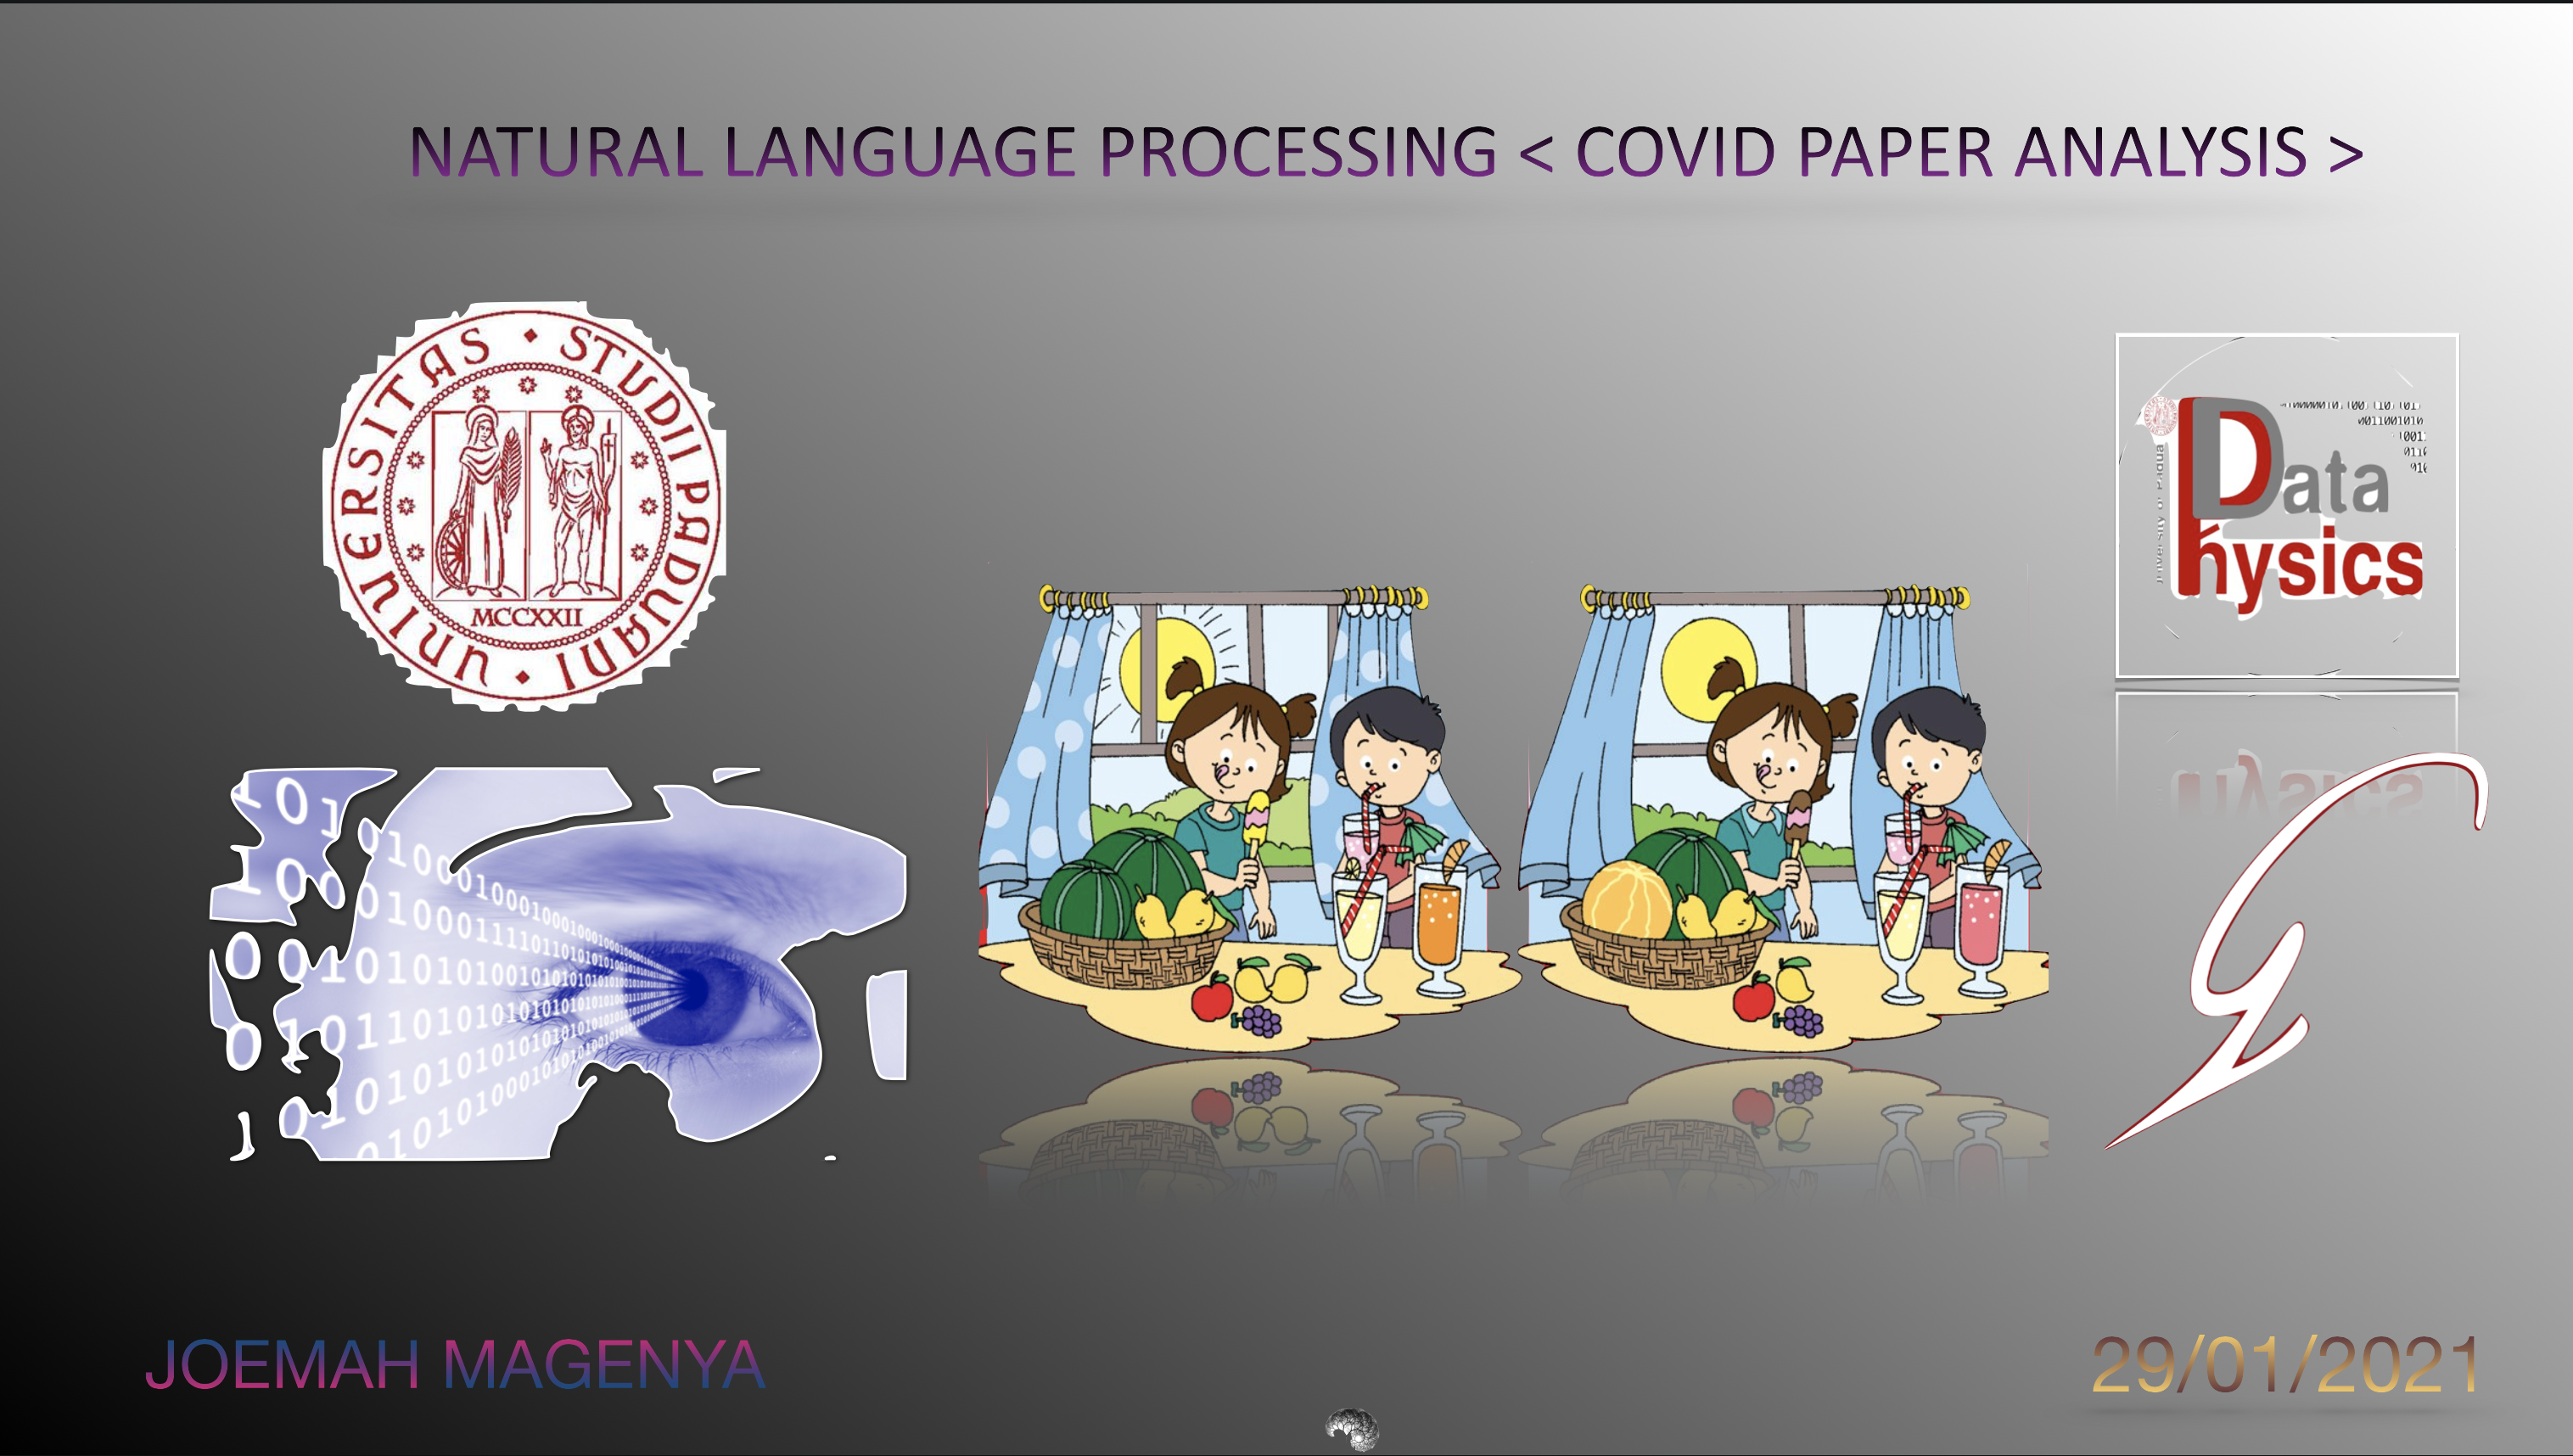

## Dataset Description
 https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

In [1]:
from dask.distributed import Client, LocalCluster
from operator import itemgetter, add, iconcat 
from collections import Counter
import bokeh.palettes as palette
import matplotlib.pyplot as plt
import dask.dataframe as ddf
from dask import delayed
import dask.bag as db
import seaborn as sns
import numpy as np
import pandas as pd
import functools
import json
import time
import re
import os
import io

In [2]:
import nltk # natural language toolkit
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from tqdm.notebook import tqdm

In [3]:
import random
random.seed(500)
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

In [5]:
#import nltk
#nltk.download('punkt')
#nltk.download('words')

In [6]:
# create a client
client = Client()
client

<Client: 'tcp://127.0.0.1:63976' processes=4 threads=12, memory=17.18 GB>

# Load  files 

In [7]:
def load_data():
    """
        read the files
    """
    path = 'mapdata/' #  path  containing papers 
    files = os.path.join(path, '*.json') # load json objects to files
    data = db.read_text(files) # unpack the loaded json objects    
    return data

In [8]:
data = load_data()

In [9]:
js_data = data.map(json.loads).repartition(10) # partition the data to speed up the computatation
# js_data.take(1)

In [10]:
def concate_text(js_data):
    """
    For each paper, consider the body_text and merge the result to a single body_text. 
    Select the body_text field and merge all  the text fields within it
    Input:
        js_data --> (bag) containing loaded json files 
    Ouput:
        text   ---> text  for all  papers in the body_text field 
    """
    text = '' # initialize an empty string
    text += str([pap['text'] for pap in js_data])
    
    return text

In [11]:
body_text = js_data.pluck("body_text").map(concate_text) # to be analysed

In [12]:
#body_text.take(1)

#  Preprocessing


In [13]:
def text_preprocessing(text):
    """
        Clean text for processing:
        - convert all characters into lower cases to avoid dublication 
        - remove all irrelevant characters (numbers && punctuation)
        - remove any  urls 
        - remove any emails
        Input:
            text ----> string containing text to be cleaned for processing
        Ouput:
            returns:
                clean_text ----> clean  'string'
                
    """
    clean_text = text.lower()
    urls = re.compile('(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)')
    clean_text = urls.sub('', clean_text)
    pattern    = re.compile('[^a-zA-Z\d\s]')
    pattern2 =  r"((?<=^)|(?<= )).((?=$)|(?= ))"
    clean_text = re.sub("\s+", " ", re.sub(pattern2, '', clean_text).strip())
    clean_text = re.sub(r"\b[a-zA-Z]\b", "", clean_text)
    citations  = re.compile('\[[\d]+\]')
    numbers    = re.compile('((^|\s)[\d]+)')
    text = re.sub(r'(?:^| )\w(?:$| )', ' ', clean_text).strip()
    regex = r'\S*@\S*\s?'
    clean_text = re.sub(regex, '', clean_text)
    clean_text = numbers.sub('', clean_text)
    clean_text = citations.sub('', clean_text)
    clean_text  = re.sub("\d+", "", clean_text)
    clean_text = re.sub(r'[^\w\s]','', clean_text)
    clean_text = re.sub(r"([a-z\.!])([A-Z])", r"\1 \2", clean_text)
    clean_text = re.sub(r'((?<=[a-z])[A-Z]|(?<!\A)[A-Z](?=[a-z]))', r' \1', clean_text)
    clean_text = pattern.sub('', clean_text)
    
    return clean_text

In [14]:
clean_text = body_text.map(text_preprocessing)

In [15]:
#clean_text.take(1)

In [28]:
def remove_some_words(clean_text):
    """ 
     Removes stopwords in the text <> common words in language which do not carry important meaning <>.
     Also clear all words with length less than 3
     Input:
         text (string) 
     Output: 
         text ----> list of <tokens> 
    """
    not_useful = {'the', 'however',  'et', 'this', 'using','used', 'al', 'cm',
              "as", "or", "it", "et", "also", "may", "In"}
    tokens = word_tokenize(clean_text)
    #words = set(nltk.corpus.words.words())
    #text = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())
    stop_words = set(stopwords.words('english'))
    stop_words = stop_words.union(not_useful)
    text = [w for w in tokens if not w in stop_words] 
    text = ' '.join([str(item) for item in text ])
    text = re.sub(r'\s{3,}', ' ', text).strip()
    text = ' '.join([w for w in text.split() if len(w)>3])
    text =  word_tokenize(text)
    
    return text

In [29]:
text = clean_text.map(remove_some_words) # ready for analysis

In [31]:
#text.take(1)[0][:]


#  Text Analysis

### The Algorithm 

Implementing a distributed algorithm to count the occurrences of all the words inside a list of documents using Bag data-structure of DASK. 
#### Map phase
*  for each document $D_i$, it produces the set of intermediate pairs $(w, cp(w))$, one for each word $w \in D_i$, where $cp(w)$ is the number of occurrences of $w$ in $D_i$.

#### Reduce phase 
- for each word $w$, gather all the previous pairs $(w, cp(w))$ and return the final pair $(w,c(w))$ where $c(w)$ is the number of occurrences of $w$ for all the Documents. In other words, $c(w)$ is equal to $\sum_{k=1}^n {cp}_{k} (w)$.

In [32]:
def sum_words(text):
    """ 
    Compute the number of occurence for each unique word in the text.
    Input:
        text , ---> text containing the words 
    Ouput:
        word_sum ----> dictionary containing words and their number of appearance
    """
    word_occu = {} # create an empty dictionary 
    d = dict()  # initialize an empty  dictionary
    for word in text: 
        # check if the word is already exists
        if word in d: 
            d[word] = d[word] + 1 # increment the counting by 1
        else: 
            d[word] = 1             # append the word to the dictionary
    for key in list(d.keys()):  
        word_occu[key] = d[key]
    word_sum = [{"word":x , "appearance": y} for x,y in word_occu.items()] # append a dictionary of word and its occ
    
    return word_sum

In [33]:
count_words = text.map(sum_words)
#count_words.take(1)

In [34]:
def sum_all_words(sum_word, word):
    """
        sum the frequency of every unique word in  all  papers 
    """ 
    return sum_word + word['appearance']

In [35]:
words_sum = count_words.flatten().foldby('word', binop=sum_all_words, # use the DASK function 'foldby', 
                                      initial=0, combine=add, 
                                      combine_initial=0).compute()

In [36]:
def sort_words(words_sum):
    """ 
    Sort the words in order of the number of appearence.
    Input:
        words_sum, ---> list containing unique words and their number of appearance.
    Output:
        ordered_words --->  words  with respect to their frequencies in ascending order.
    """
    ordered_words = sorted(words_sum, key = itemgetter(1), reverse= True )
    
    return ordered_words

In [37]:
def words_data_frame():
    """
    Create a dataframe of the words 
    Input:
        ordered_words
    Ouput:
        words_dataframe
    """
    ordered_words = sort_words(words_sum) # get the list of ordered words
    words_dataframe = pd.DataFrame(ordered_words, columns =['word', 'num_of_occurence']) 
    
    return words_dataframe

In [38]:
ordered_words_df = words_data_frame()

In [39]:
#ordered_words_df.head(10)

## Plot words 
 The words with the highest frequency, are the ones which were common and thus important in the virus research. 


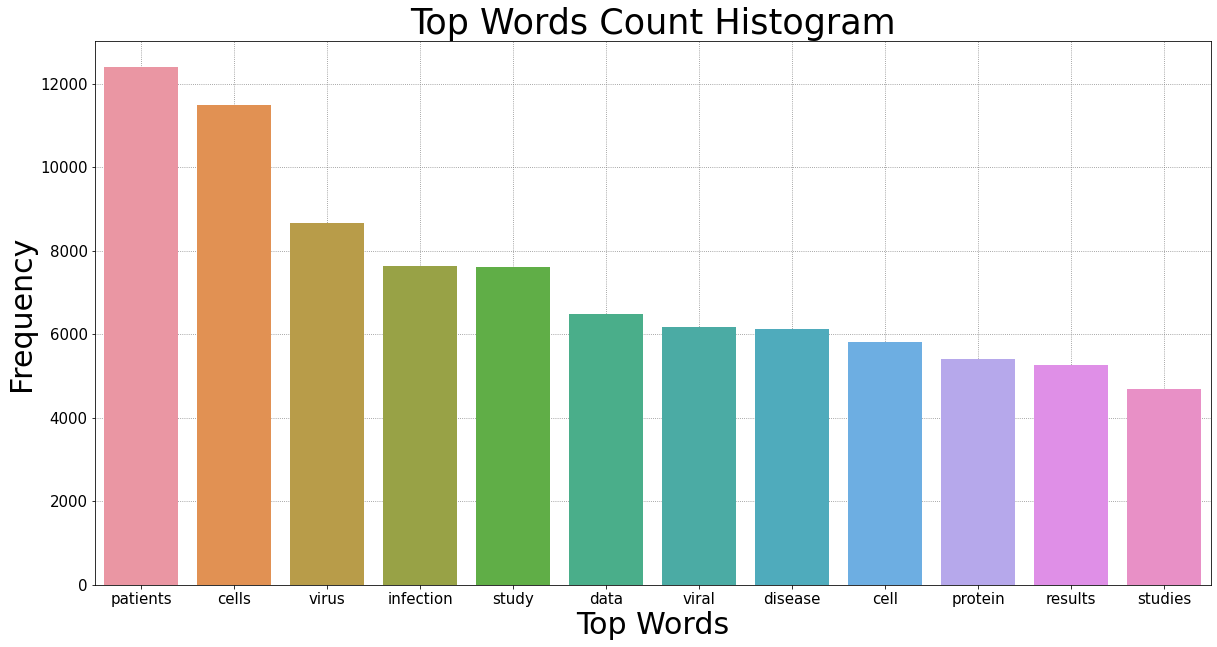

In [40]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x="word", y="num_of_occurence",data=ordered_words_df[:12], ci = None)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title('Top Words Count Histogram', fontsize = 35)
ax.grid(True, which="both", ls=":",color='0.5')
ax.set_ylabel('Frequency',fontsize = 30)
ax.set_xlabel('Top Words', fontsize = 30)
ax.set_axisbelow(True)
plt.show()

### Text Extraction Optimization

In [42]:
def compute_time(workers=5, partitions=10):
    """
        Analysis the time taken to get the words and thier frequency 
        using different number of workers in the cluster 
        Input:
            workers <int>    ----> number of workers for the cluster < default = 5> 
            partitions <int> ----> number of partitions in which the data is divided.
        Output:
            time_elapsed <float> ----> the time taken to run the distributed algorithm in seconds
    """
    cluster = LocalCluster(n_workers=workers) # create a cluster
    client = Client(cluster) # create a client
    start = time.time()  # initialize the time
    
    # Load data and repartition
    data = load_data() 
    js_data = data.map(json.loads).repartition(partitions)
    body_text = js_data.pluck("body_text").map(concate)
    clean_text = body_text.map(text_preprocessing) 
    text = clean_text.map(remove_some_words)
    count_words = text.map(sum_words)
    words_sum = count_words.flatten().foldby('word', binop=sum_all_words, 
                                      initial=0, combine=add, 
                                      combine_initial=0).compute()
    ordered_words = sort_words(words_sum)
    stop = time.time() 
    
    time_elapsed = stop - start
    client.close()
    cluster.close() 
    
    return time_elapsed

In [36]:
num_partitions = True

In [37]:
num_workers = [1,5, 15, 25, 50] # create an array of number of workers

part_factors = [1,2,3,4,5]  # create an array of partitions factors

elapse = []
partitions = []

In [38]:
if(num_partitions):
    time_elapsed = np.zeros((len(num_workers),len(part_factors))) 
    for w in range(len(num_workers)):
        for p in range(len(part_factors)):
            time_elapsed[w][p] = compute_time(num_workers[w],part_factors[p]*num_workers[w])
            elapse.append(time_elapsed[w][p])
            partitions.append(part_factors[p]*num_workers[w])
            #print("num_workers: ", num_workers[w], " partitions: ", part_factors[p]*num_workers[w], f"time: {round(time_elapsed[w][p], 3)}s")

###  Plot times 

In [59]:
def plot_part(time_elapsed, n_workers, title='Text time analysis'):
    plt.figure(figsize=(15, 8))
    linefmt = ['yo:','r-.','ko:', 'co-', 'm:']
    markerfmt = ['yD', 'rd','ko' ,'cp', 'm8']
    dim=np.arange(1,6,1)
    for i in range(5):
        plt.stem([1, 2,3, 4, 5], time_elapsed[i],linefmt=linefmt[i], 
                 markerfmt= markerfmt[i],label=f'num_workers,={n_workers[i]}',
                 basefmt=None,  use_line_collection=True)
        plt.grid(True,color='r', linestyle='--', linewidth=0.15)       
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xticks([1, 2,3, 4, 5])
        plt.title(title, fontsize=30)
        plt.ylabel('Time_Elapsed (s)', fontsize=20)
        plt.xlabel('Partition Factor', fontsize=20)
    plt.show()

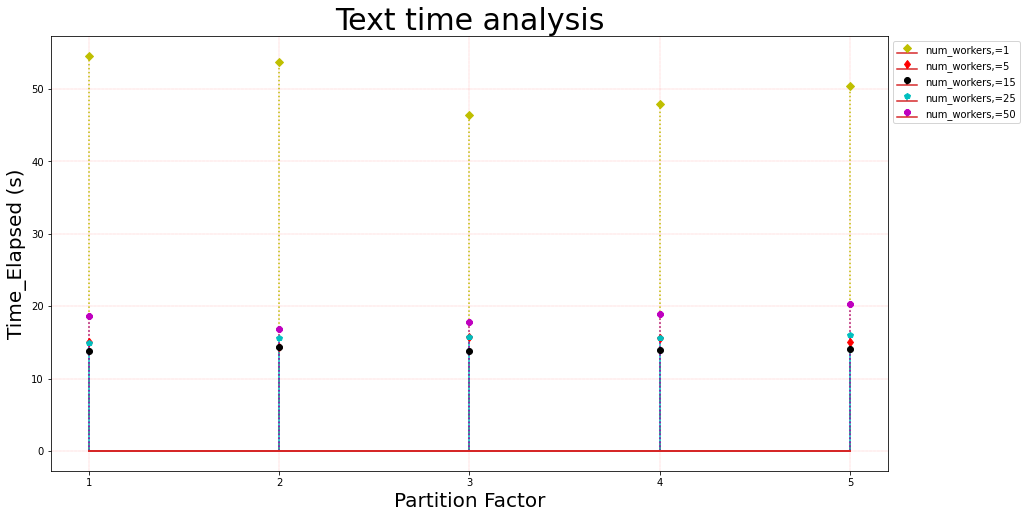

In [60]:
plot_part(time_elapsed, num_workers)

## Heatmap 

In [63]:
def plot_times(time_elapsed,part_factors,num_workers,title='Text time analysis', cmap='Set2'):
    """
    Plot the time taken to  execute some code
    Input:
        time_elapsed, -----> an array containing times for each num_worker
        part_facttors,  ---> an array of partition factors
        num_workers,  ----> an array of number of workers
    """
    time_data = pd.DataFrame(time_elapsed.T, part_factors, num_workers) # create dataframe of time elapsed
    plt.figure(figsize=(15,8))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(time_data, annot=False, annot_kws={"size": 16},fmt=".3f",
               cbar_kws={'label':'Time_Elapsed (s)'},cmap=cmap)
    plt.xlabel('num_workers',fontsize=16)
    plt.ylabel('partition_factors',fontsize=16)
    plt.title(title, fontsize=30)
    plt.show()
    plt.style.use('default')

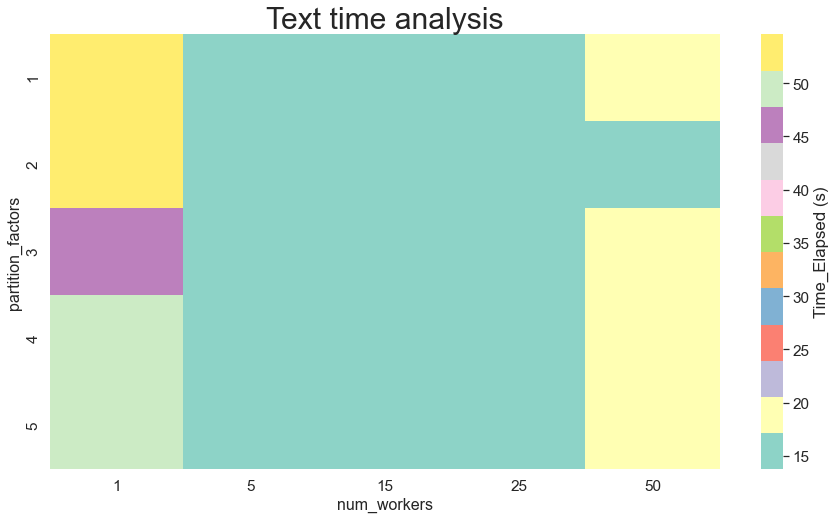

In [64]:
plot_times(time_elapsed,part_factors,num_workers, cmap='Set3')

# Countries in the Research Analysis


In [67]:
def get_authors(data):
    """
    Get the data related to  authors in the research.
    Input:
        data, ----> papers about covid research
    Output:
        authors, dictionary  containing all authors involved in the research
    """
    js_data = data.map(json.loads).repartition(10)
    authors = js_data.pluck('metadata').pluck('authors')
    
    return authors

In [68]:
authors = get_authors(load_data())
#authors.take(1)

In [69]:
def get_researchers(author):
    """
    Get the author details.
    Input:
        author, -----> author involved in the research
    Outpu:
        dictionary countaing author's details
    """
    uni = loc = lab = ''
    uni=author['affiliation']['institution'] if 'institution' in author['affiliation'].keys() else ""
    lab= author['affiliation']['laboratory'] if 'laboratory' in author['affiliation'].keys() else ""
    if 'location' in author['affiliation'].keys():
        if 'country' in author['affiliation']['location'].keys():
            loc=author['affiliation']['location']['country']
        else: loc=''
    else: loc=''
    return {
        'name':       author['first'],
        'surname':    author['last'], 
        'University': uni,
        'Laboratory': lab,
        'Country':    loc,
        }

###  create authors dataframe

In [70]:
auth_df = authors.flatten().map(get_researchers).to_dataframe()
auth_df.tail(4)

name            surname  \
574  Eckart           Schreier   
575       E            Riestra   
576       Ó  Martínez González   
577       Y       Frutos Vivar   

                                            University  \
574     U. Künkel · E. Schreier · Robert Koch-Institut   
575  Unidad de Cuidados Intensivos. Hospital Univer...   
576  Unidad de Cuidados Intensivos. Hospital Univer...   
577  Unidad de Cuidados Intensivos. Hospital Univer...   

                                            Laboratory            Country  
574                                                                        
575  Unidad de Cuidados Intensivos. Hospital Univer...  España., . España  
576  Unidad de Cuidados Intensivos. Hospital Univer...  España., . España  
577  Unidad de Cuidados Intensivos. Hospital Univer...  España., . España

##  Time analysis

In [71]:
def evaluate_time(partitions, num_workers, mapping='Country'):
    """
        Check  the time it takes to  get countries involved in research
        Input: 
            partitions, ------> list of partitions
            num_workers, -------> list of number of workers 
        Return: 
            elapsed_time (s) ----> the time taken to compute the procedure above
    """
    cluster = LocalCluster(n_workers = num_workers)
    client = Client(cluster) 
    start = time.time() 
        
    authors = get_authors(data)
    auth_df = authors.flatten().map(get_researchers).to_dataframe()
    grouped_data = auth_df.groupby(mapping).name.count().compute() 
    sort_data = grouped_data.sort_values(ascending=True) 
    stop = time.time()
    
    client.close()
    cluster.close() 
    time_elapsed = stop - start
    
    return time_elapsed

### Countries Time analysis

In [72]:
part_factors = [1, 2, 3, 4, 5]
num_workers  = [1, 5,15, 25, 50]

elpsed_time =  []
time_elapsed = np.zeros((len(num_workers),len(part_factors))) 
for w in tqdm(num_workers, leave=False):
    for p in tqdm(part_factors, leave=False):
        time_taken[w][p] = evaluate_time(partitions = p*w, num_workers = w)
        elpsed_time.append(time_taken)
        #print(f"Workers= {w}", f"Partitions={p*w}", f"time = {time_taken}s")

In [88]:
elpsed_time = np.array([elpsed_time[i:i+5] for i in range(0, len(elpsed_time), 5)])

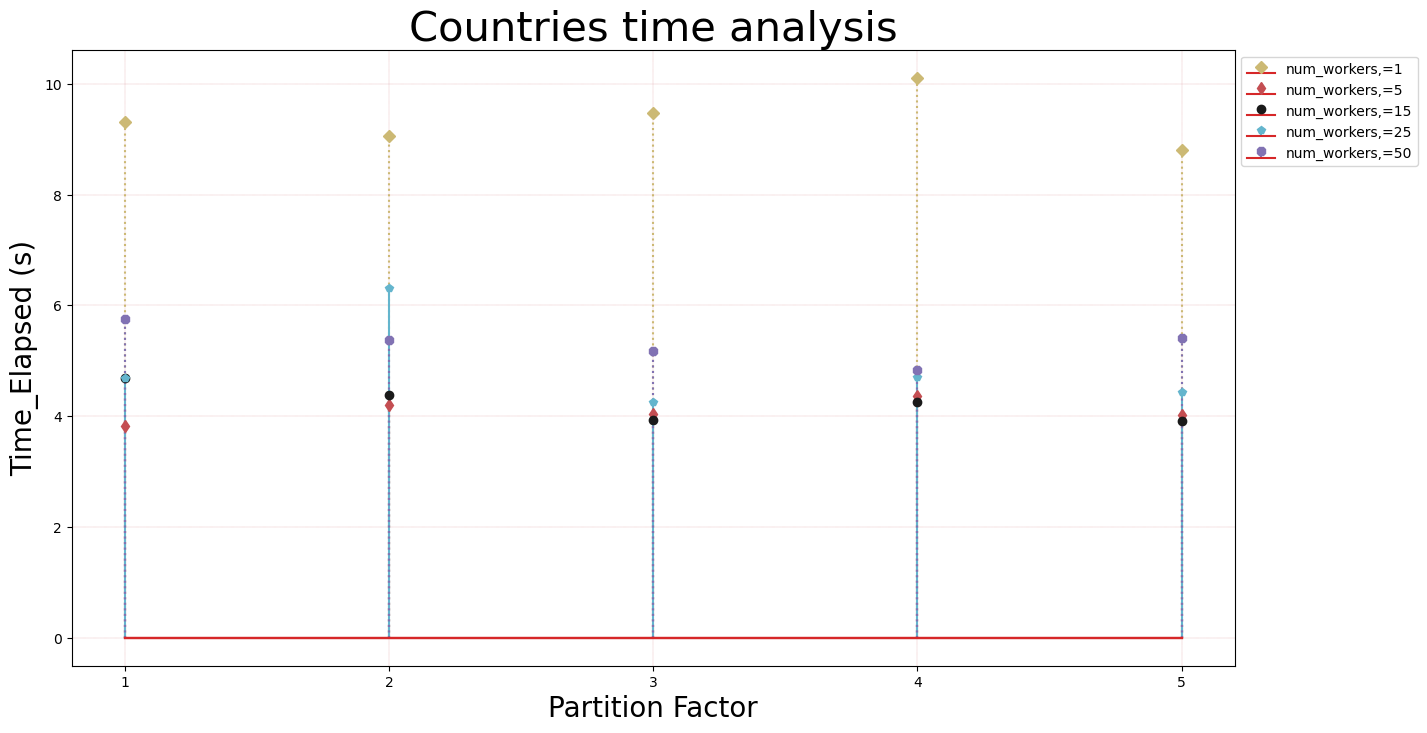

In [89]:
plot_part(elpsed_time, num_workers, title='Countries time analysis')

##  Heatmap 

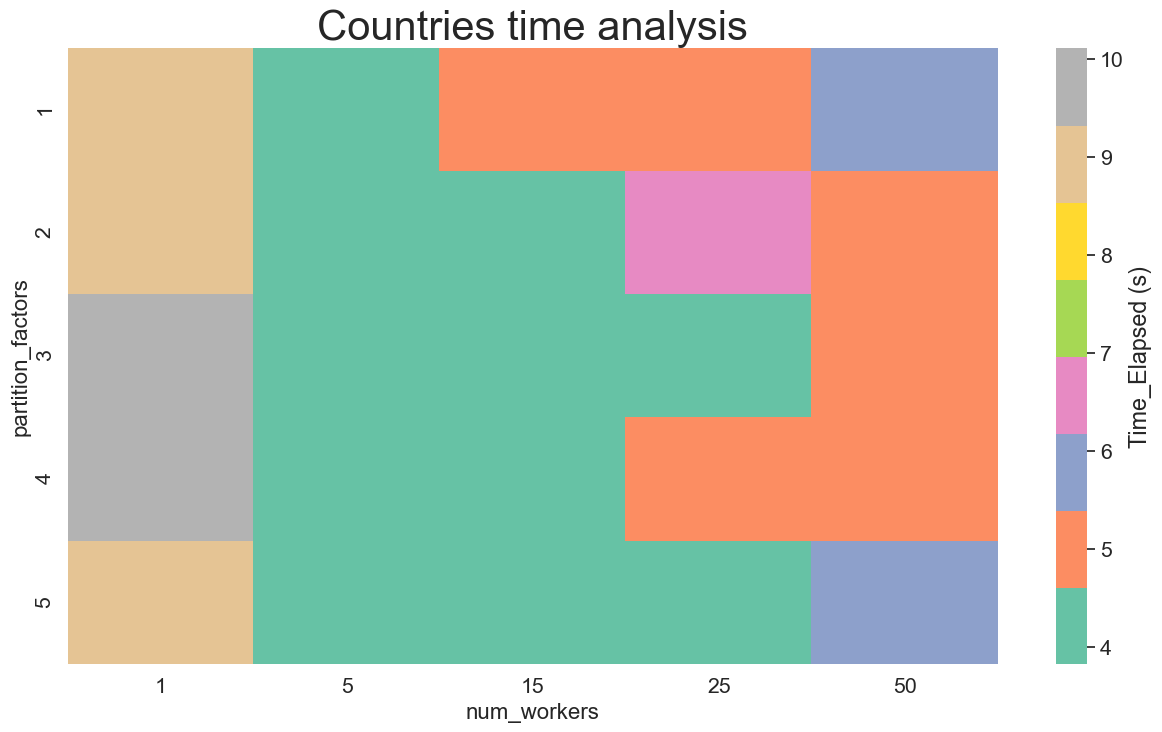

In [95]:
plot_times(elpsed_time, part_factors,num_workers,title='Countries time analysis', cmap='Set2')

### Universities Time analysis

In [96]:
part_factors = [1, 2, 3, 4, 5]
num_workers  = [1, 5,15, 25, 50]

elpsed_time =  []

for w in tqdm(num_workers, leave=False):
    for p in tqdm(part_factors, leave=False):
        time_taken = evaluate_time(partitions = p*w, num_workers = w,mapping='University')
        elpsed_time.append(time_taken)
        #print(f"Workers= {w}", f"Partitions={p*w}", f"time = {time_taken}s")

In [98]:
elpsed_time = np.array([elpsed_time[i:i+5] for i in range(0, len(elpsed_time), 5)])

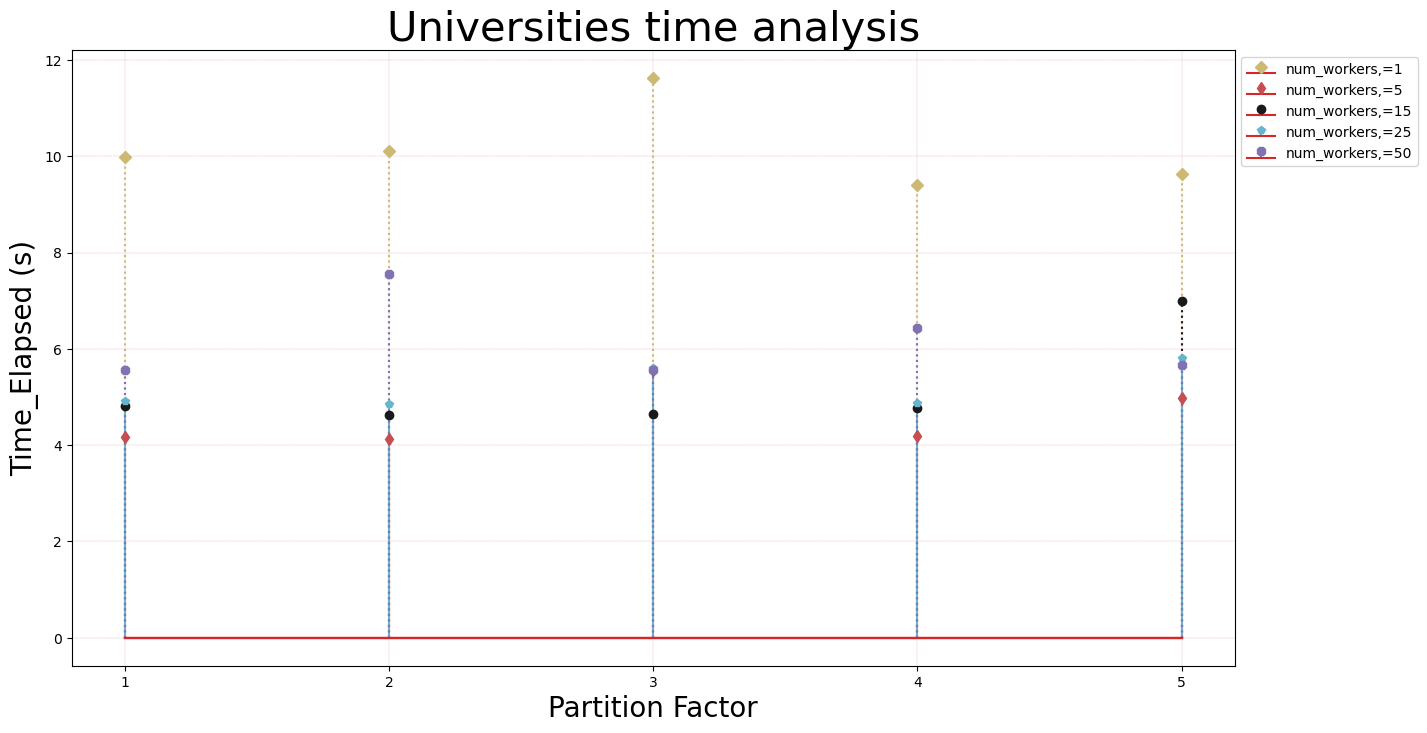

In [99]:
plot_part(elpsed_time, num_workers, title='Universities time analysis')

## Heatmap

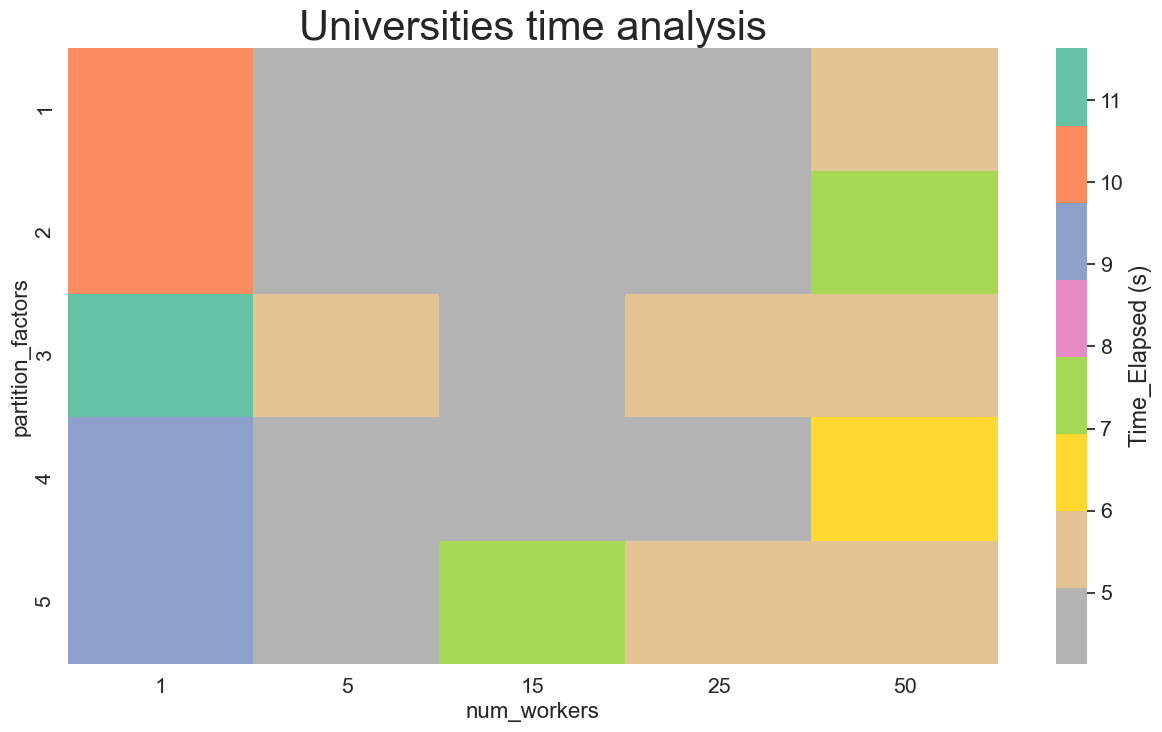

In [102]:
plot_times(elpsed_time, part_factors,num_workers,title='Universities time analysis', cmap='Set2_r')

## Plots

In [100]:
def plot_top(data, n, label,title='Distribution of Top Countries In Research',coef=0.5, uni=False, country=False, rot=0):
    """
    Plot the distributions of top  Countries or Universities involved in research
    """
    data = data.nlargest(n+1).compute()
    data = data[data.axes[0]!='Unknown']
    height = [data[i] for i in range(1,n)]
    bars = [data.axes[0][i] for i in range(1,n)]
    y_pos = np.arange(len(bars))
    
    fig, ax = plt.subplots(figsize=(15,n*coef))
    idx = n

    if country == True:
        ax.bar(y_pos[:idx], height[:idx],color=palette.cividis(idx))
        plt.xticks(y_pos[:idx], bars[:idx])
        
    if uni==True:
        ax.bar(y_pos[:idx], height[:idx],color=palette.inferno(idx),align='edge', width=0.5)
        plt.xticks(y_pos[:idx], bars[:idx], rotation=rot)
        plt.tick_params(axis='both', which='major', labelsize=10)
        
    ax.grid(True, which="both", ls=":",color=r'0.75')
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title(title, fontsize=20)
    ax.set_axisbelow(True)
    ax.set_ylabel(label[1], fontsize=20, color='c')
    ax.set_xlabel(label[0], fontsize=20, color='m')
    pl.show()

### Plot countries

In [ ]:
countries = auth_df.Country.value_counts()

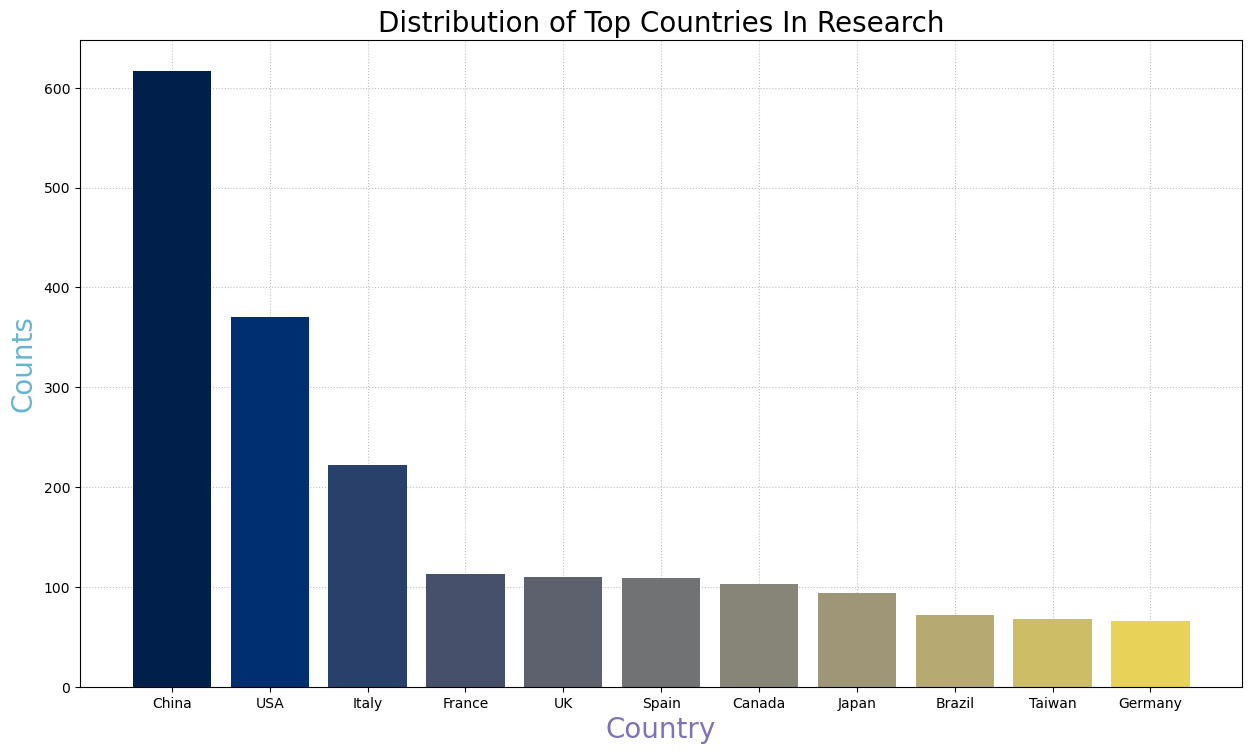

In [101]:
plot_top(countries, 12, ["Country", "Counts"],coef=0.7, uni = False, country = True)

### Plot Universities

In [ ]:
univs = auth_df.University.value_counts()

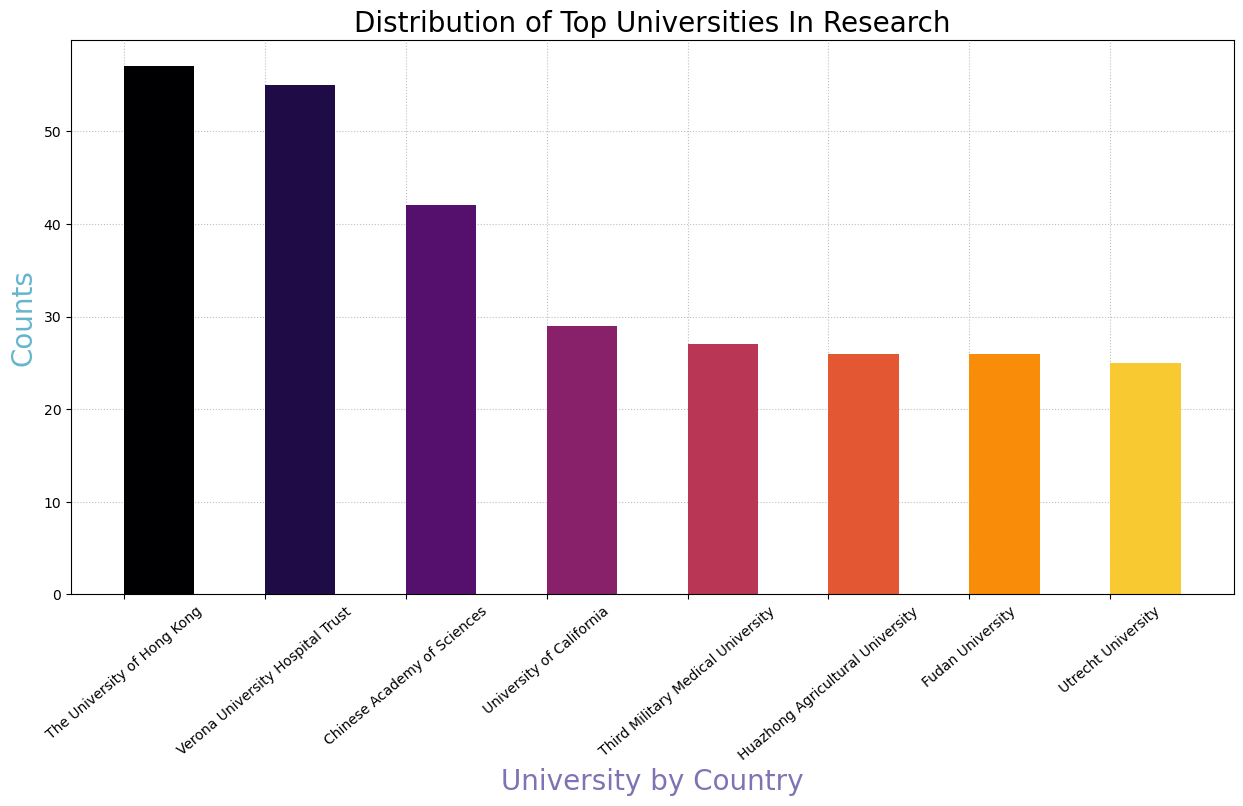

In [103]:
plot_top(univs,9,["University by Country","Counts"],title='Distribution of Top Universities In Research',
         uni = True, country=False, rot=400, coef=0.8)

# Word Embeddings 

In NLP a common technique to perform analysis over a set of texts is to transform the text to a set of vectors each one representing a word inside a document


In [17]:
client = Client(processes=False) # set to multithreading mode (disable multiprocessing)
client

<Client: 'inproc://172.20.10.14/28805/1' processes=1 threads=12, memory=17.18 GB>

In [18]:
path = '/Users/joemah/Documents/MAPD/mapdata/'
data = os.path.join(path, '*.json')
js_data = db.read_text(data).map(json.loads)

##  Download the Model (fastText)

In [19]:
def get_words_list(file):
    """
    Get  the words in text
    Input:
        file, ---> file containing pretrained text 
    Output:
        return
            words, embeddings --> vectors of words
    """
    words = {} # initialize an empty dictionary
    
    with io.open(file, 'r', encoding='utf-8', newline='\n', errors='ignore') as name:
        num_words, dim = map(int, name.readline().split()) #  n = number of words , dim = vector dimension
        embeddings = np.zeros((num_words, dim), dtype=np.float32)
        
        with tqdm(total=num_words) as prog_bar:
            for i, line in enumerate(name):
                list_of_words = line.rstrip().split(' ')
                words[list_of_words[0]] = i
                embeddings[i, :] = np.array(list_of_words[1:], dtype=np.float32) 
                prog_bar.update(1)
                
        return words, embeddings

In [20]:
path_to_word_vec = "/Users/joemah/Documents/MAPD/wordvec/"

In [21]:
word_list, embeddings = get_words_list(path_to_word_vec + 'wiki.en.vec')

In [22]:
def get_title_embeddings(title):
    """
    Compute the embeddings for each  paper 
    Input:
        title ----> title for the research paper  
    Output:
        return an array of title embeddings
    """
    #words = title.strip().split()
    title_embedding = []
    for i, word in enumerate(title):
        idx = word_list.get(word, -1)
        if idx != -1: 
            title_embedding.append(embeddings[idx])
    
    return np.array(title_embedding)

In [23]:
def get_title_emb(paper):
    """
     Extract the "paper_id" and the title embedding for a given paper.
     Input:
         paper ----> json file 
    """
    title = text_preprocessing(paper['metadata']['title'])
    
    return {'paper_id' : paper['paper_id'], 'title-embedding' : get_title_embeddings(title)}

In [24]:
paper_titles = js_data.map(get_title_emb)

In [25]:
#paper_titles.take(1)

In [26]:
title_embeddings = paper_titles.compute()

In [27]:
title_embeddings[:2]

[{'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
  'title-embedding': array([[ 0.019006,  0.15585 ,  0.11008 , ..., -0.07909 ,  0.039304,
           0.041258],
         [-0.21327 , -0.39156 ,  0.1885  , ..., -0.07631 ,  0.28404 ,
           0.27578 ],
         [ 0.038464, -0.11291 , -0.17323 , ...,  0.18243 , -0.071865,
           0.094051],
         ...,
         [-0.31913 , -0.25218 ,  0.42204 , ...,  0.44076 ,  0.31126 ,
          -0.2409  ],
         [ 0.26386 , -0.07325 ,  0.037621, ...,  0.23706 , -0.45787 ,
           0.051434],
         [-0.089375,  0.14391 ,  0.10134 , ..., -0.019988,  0.17858 ,
           0.1463  ]], dtype=float32)},
 {'paper_id': '000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a',
  'title-embedding': array([[-0.013152, -0.29961 ,  0.12982 , ...,  0.17816 ,  0.24468 ,
           0.21235 ],
         [-0.23323 , -0.27436 , -0.10449 , ...,  0.058304,  0.24731 ,
           0.31659 ],
         [-0.31913 , -0.25218 ,  0.42204 , ...,  0.44076 ,  0.31126 ,
        

# Cosine Similarity


$$\Large Sim(Pap1, Pap2) = \cos(\theta) = \dfrac{Pap1 \cdot Pap2 }{\left\lVert Pap1 \right\rVert \left\lVert Pap2 \right\rVert}$$



In [28]:
def compute_similarities(title_emb):
    """
    Computes the similarities  of papers involved in the research
    Input:
        title_emb ----> list of dictionaries to extract title embedings
    Output:
        similarities -----> the similarities between two papers in comparizon
    """
    def get_cosine(pap1, pap2):
        """
        Input:
           pap1, pap2 ---> vectors of two titles to be compared
        """
        cosine = np.dot(pap1, pap2)/(np.linalg.norm(pap1) * np.linalg.norm(pap2))
        
        return cosine
        
    pap1_embedding = title_emb["title-embedding"].flatten() # set as pivot
    similarities = np.zeros(len(title_embeddings), dtype=np.float32)
    
    for i, pap in enumerate(title_embeddings):
        pap2_embedding = pap["title-embedding"].flatten()
        length = min(len(pap1_embedding), len(pap2_embedding)) # common length 
        pap1   = pap1_embedding[:length]
        pap2   = pap2_embedding[:length]
        similarities[i] =  get_cosine(pap1, pap2) 
    
    return similarities

In [29]:
similarities = db.from_sequence(title_embeddings).map(compute_similarities)

In [30]:
similarities =  np.array(similarities.compute()) 

In [33]:
similarities[:6]

array([[0.        , 0.34407854, 0.32173097, ..., 0.34093466, 0.33701384,
        0.        ],
       [0.34407854, 0.        , 0.30807778, ..., 0.3305074 , 0.3192793 ,
        0.        ],
       [0.32173097, 0.30807778, 0.        , ..., 0.34620547, 0.33539653,
        0.        ],
       [0.34568578, 0.31354076, 0.3532449 , ..., 0.3347609 , 0.32384375,
        0.        ],
       [0.33481807, 0.35686633, 0.35143483, ..., 0.3321395 , 0.36659375,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [43]:
#### remove any nan values and the diagonal

In [34]:
similarities[np.isnan(similarities)] = 0               
similarities[np.diag_indices(len(similarities))] = 0  

In [35]:
def get_title(paper):
    """
    Get the "paper_id" and the title for a given paper.
    Input:
        paper ---> (json file) ::paper involved in research
    Output:
        return a dictionary
    """
    title = text_preprocessing(paper['metadata']['title'])
    title = title.replace("journal preproof", "")
    
    return {'paper_id' : paper['paper_id'], 'title-embedding' : title}

In [36]:
titles = js_data.map(get_title).to_dataframe().compute()

In [37]:
sorted_similarities = np.argsort(-similarities, axis=None)         # sort in descending order
sorted_indices = np.unravel_index(sorted_similarities, similarities.shape)

###  Similarities Dataframe

In [38]:
titles1 = []
titles2 = []
sim_pap1_pap2 = []
pap1_idxs = []
pap2_idxs = []

In [39]:
for i in range(10000):
    pap1_idx = sorted_indices[0][i]
    pap2_idx = sorted_indices[1][i]
    pap1 = title_embeddings[pap1_idx]['paper_id']
    pap2 = title_embeddings[pap2_idx]['paper_id']
    pap1_title = titles.loc[titles['paper_id'] == pap1]['title-embedding'][0]
    pap2_title = titles.loc[titles['paper_id'] == pap2]['title-embedding'][0]
    sim = similarities[pap1_idx, pap2_idx]
    titles1.append(pap1_title)
    pap1_idxs.append(pap1_idx)
    pap2_idxs.append(pap2_idx)
    titles2.append(pap2_title)
    sim_pap1_pap2.append(sim)

In [40]:
dataframe = pd.DataFrame(list(zip(pap1_idxs, titles1, pap2_idxs, titles2, sim_pap1_pap2)),
                  columns =['Index_p1', 'Paper1', 'Index_p2', 'Paper2', 'Similarity'])

In [41]:
dataframe['Paper1'].replace('', np.nan, inplace=True)
dataframe= dataframe.dropna(subset=['Paper1'])
dataframe['Paper2'].replace('', np.nan, inplace=True)
dataframe= dataframe.dropna(subset=['Paper2'])

### Most similar papers

In [42]:
dataframe.head(8)

Index_p1                                             Paper1  Index_p2  \
14        380  role of cd cd cells in acute and persistent co...       567   
38        567  role of cd cd cells in acute and persistent co...       380   
108       577                         to appear in public health       142   
109       725  supplementary appendix preparedness and vulner...       440   
110       320                                   original article       726   
111       440                             supplementary appendix       725   
112       984  editorial perspective perils and promise for c...       410   
113       410                                          editorial       984   

                                                Paper2  Similarity  
14   role of cd cd cells in acute and persistent co...         1.0  
38   role of cd cd cells in acute and persistent co...         1.0  
108             to appear in public health in practice         1.0  
109                             supplementary appendix         1.0  
110                                   original article         1.0  
111  supplementary appendix preparedness and vulner...         1.0  
112                                          editorial         1.0  
113  editorial perspective perils and promise for c...         1.0

### Least similar papers

In [43]:
dataframe.tail(8)

Index_p1                                             Paper1  Index_p2  \
9992       561  idiopathic sterile pyogranuloma in three domes...       914   
9993       914  viral regulation of rna granules in infected c...       561   
9994       575  flagging and docking dual roles for glycans in...       188   
9995       188  twelve essentials of sciencebased policy cente...       575   
9996       140  coxsackievirus a enterovirus and acute respira...       432   
9997       432  how reliable is smartphonebased electronic con...       140   
9998       739  how immune complexes from certain igg nabs and...       981   
9999       981                    covid clue from innate immunity       739   

                                                 Paper2  Similarity  
9992  viral regulation of rna granules in infected c...    0.432495  
9993  idiopathic sterile pyogranuloma in three domes...    0.432495  
9994  twelve essentials of sciencebased policy cente...    0.432490  
9995  flagging and docking dual roles for glycans in...    0.432490  
9996  how reliable is smartphonebased electronic con...    0.432489  
9997  coxsackievirus a enterovirus and acute respira...    0.432489  
9998                    covid clue from innate immunity    0.432486  
9999  how immune complexes from certain igg nabs and...    0.432486

In [44]:
import seaborn as sns

#  Plot Similarities

### Heatmap

In [129]:
def plot_similarities_heatmap(n):
    plt.figure(figsize=(16, 10), facecolor='#fcfafa')
    result = dataframe[:n].pivot(index='Index_p1', columns='Index_p2', values='Similarity')
    sns.heatmap(result, annot=False,  vmin=0, vmax=1, linewidths=0.2, linecolor='#fcfafa',
                cmap='cubehelix_r', cbar_kws={'label':'Simililarity'})
    plt.title('Title Similarities Between Paper1 and Paper2', fontsize=20, pad=10)
    plt.show()

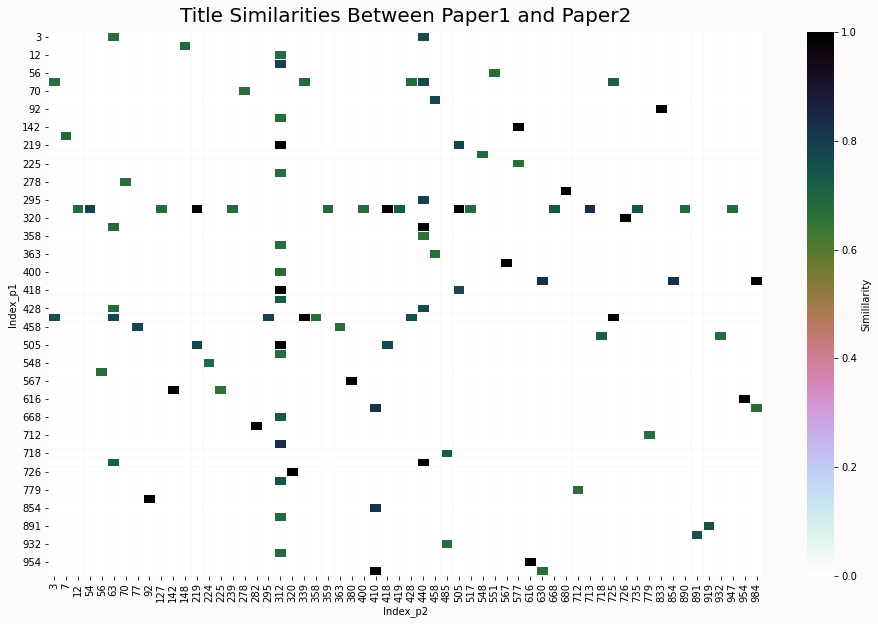

In [130]:
plot_similarities_heatmap(100)

### Correlation

In [131]:
def plot_corr_heatmap(n):
    plt.figure(figsize=(20, 12), facecolor='#fcfafa')
    plt.title('Similarities Between Covid Papers', fontsize=30, pad=10)
    sns.heatmap(dataframe[:n].groupby('Similarity').corr(), annot =False,
                cbar_kws={'label':'Correlation_Coefficient'}, 
                cmap='Paired')
    plt.show()

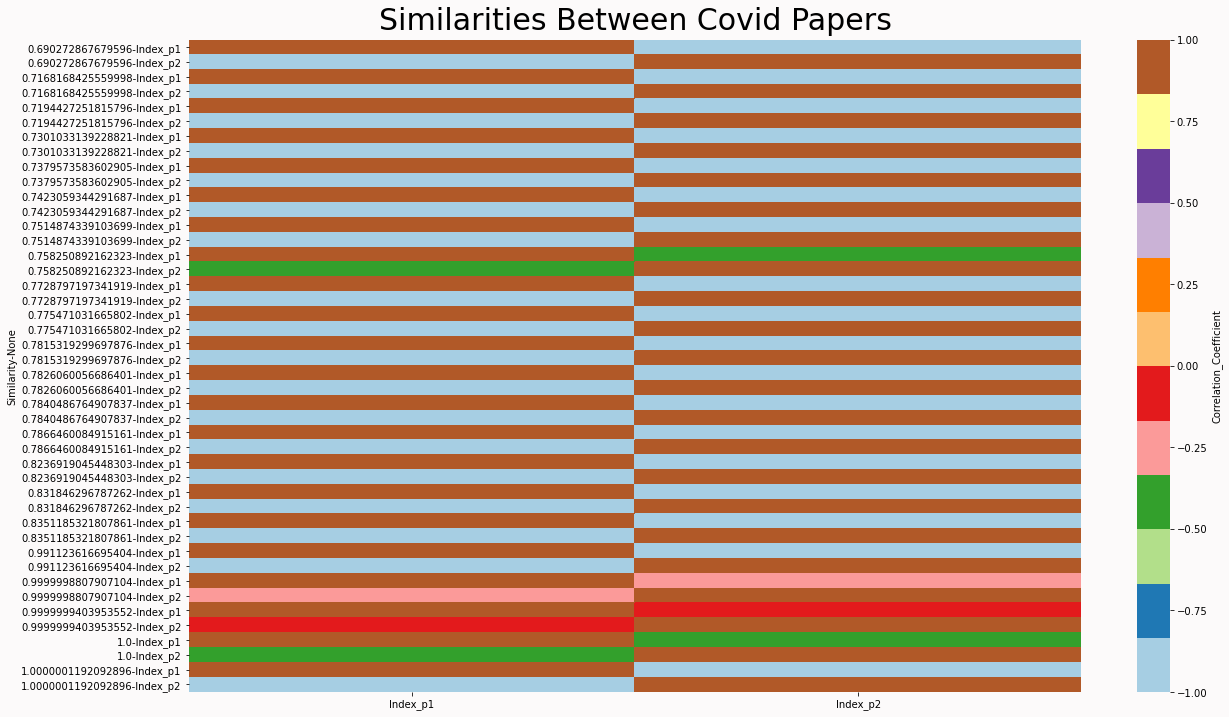

In [132]:
plot_corr_heatmap(60)

- r =  1 means that the two papers are linearly related  and the slope is positive ....

    -- r =  0 means that the is no relinear relationship thus the slope is zero


- r = -1 means that the two papers are linearly related  but the slope is negative .... 